In [1]:
%%capture
!pip install yfinance

In [2]:
import torch
import torch.nn as nn
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import yfinance as yf

# Parameters

In [3]:
ticker = "AMZN"
start = datetime.date.today() - datetime.timedelta(days=10000)
end = datetime.date.today()

n_future = 1   # Number of days we want to look (predict) into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

features_to_train_on = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
features_to_predict = ['Adj Close']

batch_size = 32 # This will affect the inputs to the deep learning model.

# Input shape = (batch_size, n_past, len(features_to_train_on))
# Output shape = (batch_size, len(features_to_predict))

# Downloading the data

In [4]:
df = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...
2023-06-15,125.209999,127.690002,124.320000,127.110001,127.110001,60458500
2023-06-16,127.709999,127.900002,125.300003,125.489998,125.489998,84188100
2023-06-20,124.970001,127.250000,124.500000,125.779999,125.779999,56930100


# EDA

Text(0, 0.5, 'Adjusted Closing Price')

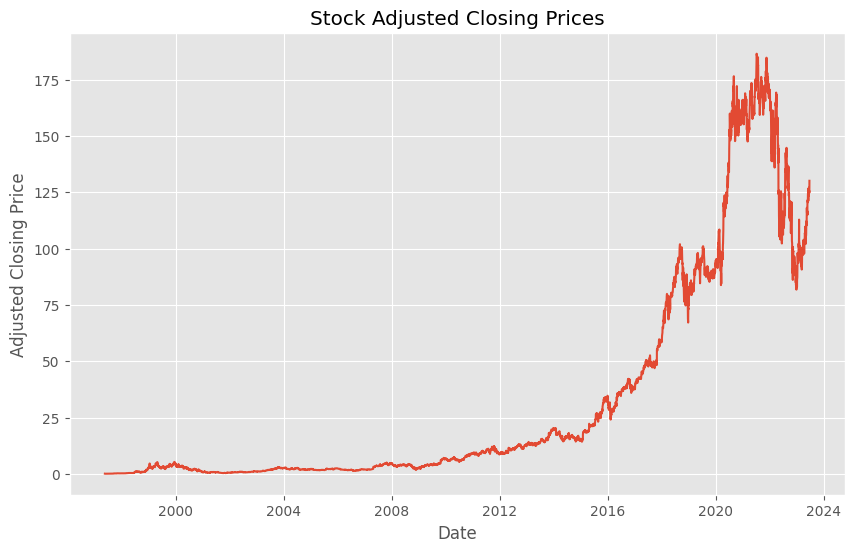

In [7]:
# Line plot of stock adjusted closing prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'])
plt.title('Stock Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')

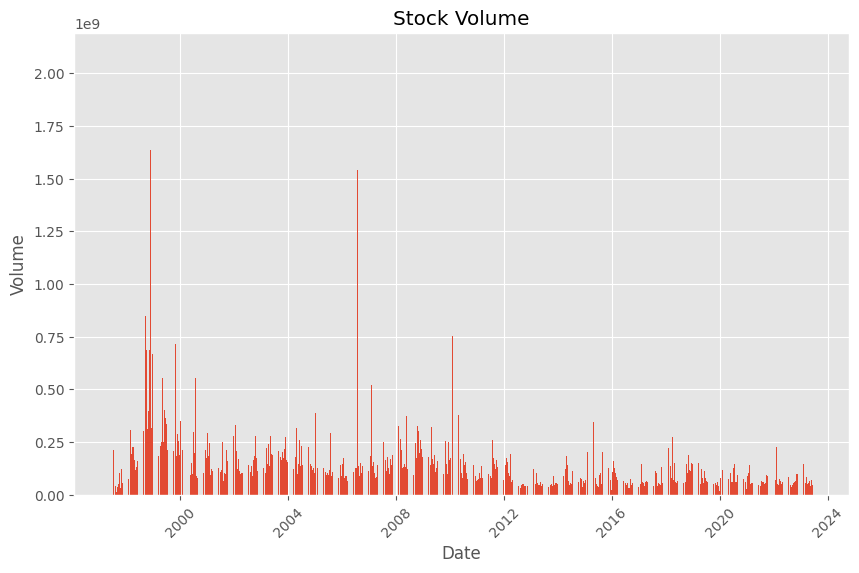

In [8]:
# Volume bar plot
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Volume'])
plt.title('Stock Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


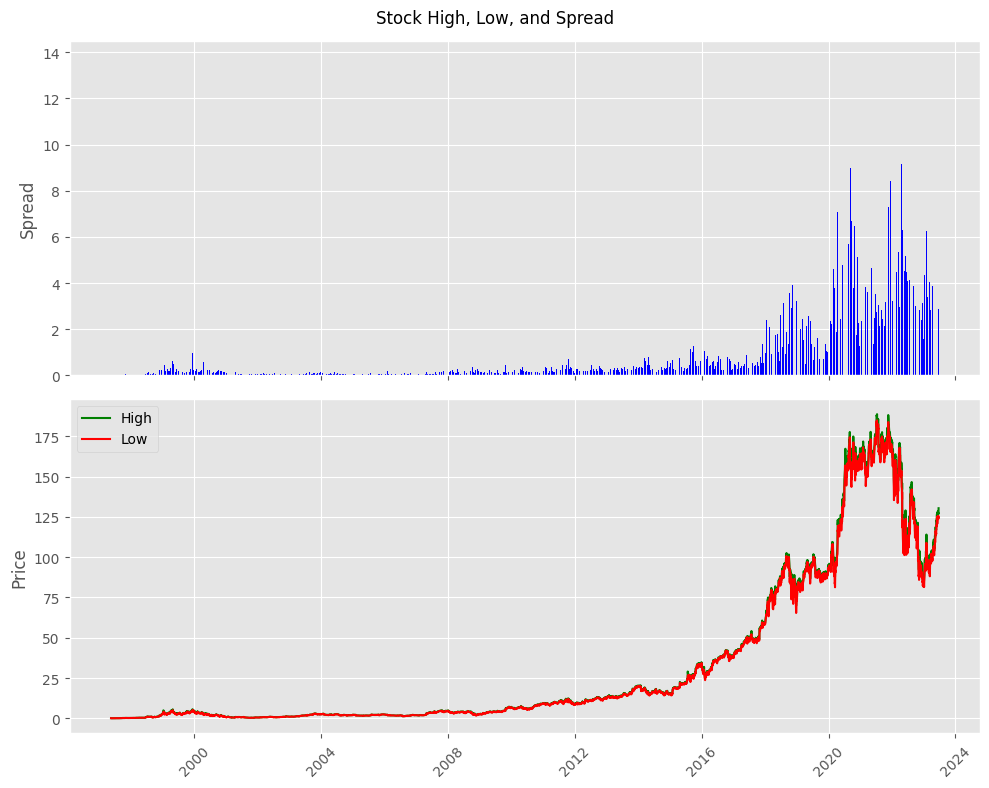

In [9]:
# Create subplots for Low/High values and spread
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Line plot for spread (High - Low)
spread = df['High'] - df['Low']
# ax1.plot(df.index, spread, color='blue')
ax1.bar(df.index, spread, color='blue')
ax1.set_ylabel('Spread')

# Bar plot for Low and High values
ax2.plot(df.index, df['High'], color='green', label='High')
ax2.plot(df.index, df['Low'], color='red', label='Low')
ax2.set_ylabel('Price')

# Set x-axis tick rotation
plt.xticks(rotation=45)

# Add a legend to the second subplot
ax2.legend()

# Add a title for the entire figure
plt.suptitle('Stock High, Low, and Spread')

# Display the plot
plt.tight_layout()
plt.show()


# Data Processing

In [10]:
features_to_predict_index = [df.columns.get_loc(feature) for feature in features_to_predict]
features_to_predict_index

[4]

In [11]:
features_to_train_on_index = [df.columns.get_loc(feature) for feature in features_to_train_on]
features_to_train_on_index

[0, 1, 2, 3, 4, 5]

In [12]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(df)

# Scale the training data using the fitted scaler
df_scaled = scaler.transform(df)

# To sanity check data X and Y are being populated correctly,
# then remove the scalar and print out values from X and Y
# after running the next cell. Then correlate with df
# df_scaled = np.array(df)

# Verify the shape of the scaled data
print("Shape of scaled data:", df_scaled.shape)


Shape of scaled data: (6569, 6)


In [13]:
# Empty lists to be populated using formatted training data
X = []
Y = []

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# Assuming df_scaled is a numpy array of shape (n_samples, n_features)
for i in range(n_past, len(df_scaled) - n_future + 1):
    X.append(df_scaled[i - n_past:i, features_to_train_on_index])
    Y.append(df_scaled[i + n_future - 1, features_to_predict_index])

# Convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Convert numpy arrays to torch tensors
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()

# Create a TensorDataset
dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)

In [14]:
print(X[0])
print(Y[0])

[[-0.66343164 -0.66358455 -0.66385527 -0.66414801 -0.66414801  9.30971354]
 [-0.66391533 -0.66411573 -0.66408398 -0.66438466 -0.66438466  1.08816883]
 [-0.66413032 -0.66432819 -0.66417112 -0.66440615 -0.66440615 -0.14145694]
 [-0.66416258 -0.66434944 -0.66416023 -0.66448145 -0.66448145 -0.23297914]
 [-0.66425931 -0.66445567 -0.66443252 -0.66469657 -0.66469657  1.68246219]
 [-0.66446354 -0.66465752 -0.66449786 -0.66472883 -0.66472883  0.66987971]
 [-0.66449578 -0.66458315 -0.66447608 -0.66462128 -0.66462128  1.26520335]
 [-0.66438829 -0.66445567 -0.66434538 -0.66453522 -0.66453522  0.22926811]
 [-0.66427006 -0.66446629 -0.66426913 -0.664589   -0.664589   -0.36073247]
 [-0.66435606 -0.66456192 -0.66432361 -0.66461591 -0.66461591 -0.51836359]
 [-0.66439905 -0.66459378 -0.66432361 -0.66462128 -0.66462128 -0.64405638]
 [-0.66438829 -0.66457252 -0.66430182 -0.66461052 -0.66461052 -0.93064281]
 [-0.66436679 -0.66457252 -0.66432361 -0.6646428  -0.6646428  -0.84598906]
 [-0.66442055 -0.66461503

In [15]:
# Set the desired percentage of test samples
test_percentage = 0.2  # Example: 20% test data

# Calculate the number of test samples based on the percentage
num_test_samples = int(len(dataset) * test_percentage)

# Calculate the number of train samples
num_train_samples = len(dataset) - num_test_samples

# Define the indices for train and test sets
train_indices = range(num_train_samples)
test_indices = range(num_train_samples, len(dataset))

# Create Subset datasets using the defined indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoaders for training and testing
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
for inputs, targets in train_dataloader:
    # inputs shape: (batch_size, n_past, n_features)
    # targets shape: (batch_size, 1)
    print('Inputs shape:', inputs.shape)
    print('Targets shape:', targets.shape)
    break

Inputs shape: torch.Size([32, 14, 6])
Targets shape: torch.Size([32, 1])


In [17]:
for inputs, targets in test_dataloader:
    # inputs shape: (batch_size, n_past, n_features)
    # targets shape: (batch_size, 1)
    print('Inputs shape:', inputs.shape)
    print('Targets shape:', targets.shape)
    break

Inputs shape: torch.Size([32, 14, 6])
Targets shape: torch.Size([32, 1])


# Machine Learning

In [18]:
# Set number of epochs
num_epochs = 50

# Set learning rate
learning_rate = 0.0001

## Model Architecture

In [19]:
# Get the input and output sizes
input_size = X.shape[2]  # Number of features in input data
output_size = Y.shape[1]  # Number of output units
sequence_length = X.shape[1] # Length of the time series (for each sample)

# Define the hidden sizes for the neural network models (same for LSTM and Conv1D)
hidden_size = 64

### LSTM

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        if self.lstm.bidirectional:
            hidden_size*=2

        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :] # Take the last time step output
        x = self.linear(x)
        return x

In [21]:
# Get the input and output sizes
input_size = X.shape[2]  # Number of features in input data
output_size = Y.shape[1]  # Number of output units

# Define the hidden sizes
hidden_size = 64

# Create an instance of the LSTM model
model = LSTMModel(input_size, hidden_size, output_size)

# Print the model summary
print(model)

LSTMModel(
  (lstm): LSTM(6, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


### CNN

In [22]:
class CNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, output_size):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size * n_past, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape input to (batch_size, input_size, sequence_length)
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x


In [23]:
# Create an instance of the LSTM model
model = CNNModel(input_size, hidden_size, sequence_length, output_size)

# Print the model summary
print(model)

CNNModel(
  (conv1d): Conv1d(6, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=896, out_features=1, bias=True)
)


### Ensemble Model

In [24]:
class EnsembleModel(nn.Module):
    def __init__(self, lstm_model, cnn_model, output_size):
        super().__init__()
        self.lstm_model = lstm_model
        self.cnn_model = cnn_model
        self.linear = nn.Linear(2, output_size)

    def forward(self, x):
        lstm_output = self.lstm_model(x)
        cnn_output = self.cnn_model(x)
        combined_output = torch.cat((lstm_output, cnn_output), dim=1)
        output = self.linear(combined_output)
        return output


In [25]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
cnn_model = CNNModel(input_size, hidden_size, sequence_length, output_size)

model = EnsembleModel(lstm_model, cnn_model, output_size)

### LSTM Conv Model

In [26]:
class LSTMConvModel(nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, conv_input_size, conv_hidden_size, output_size, sequence_length):
        super().__init__()
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)
        self.conv1d = nn.Conv1d(in_channels=conv_input_size, out_channels=conv_hidden_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(lstm_hidden_size + conv_hidden_size * sequence_length, output_size)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        lstm_output = lstm_output[:, -1, :]  # Take the last time step output

        x = x.permute(0, 2, 1)  # Reshape input to (batch_size, input_size, sequence_length)
        conv_output = self.conv1d(x)
        conv_output = self.relu(conv_output)
        conv_output = conv_output.flatten(start_dim=1)

        combined_output = torch.cat((lstm_output, conv_output), dim=1)
        output = self.linear(combined_output.unsqueeze(0))
        return output.squeeze(0)


In [27]:
lstm_input_size = conv_input_size = input_size  # Specify the input size for the LSTM layer
lstm_hidden_size = conv_hidden_size = hidden_size  # Specify the hidden size for the LSTM layer

model = LSTMConvModel(lstm_input_size, lstm_hidden_size, conv_input_size, conv_hidden_size, output_size, sequence_length)

## Training

In [28]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

        # Calculate average validation loss
        val_loss /= len(test_dataloader)
        val_losses.append(val_loss)

    # Print training and validation loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/50], Train Loss: 0.0437, Val Loss: 0.0472
Epoch [2/50], Train Loss: 0.0017, Val Loss: 0.0317
Epoch [3/50], Train Loss: 0.0010, Val Loss: 0.0178
Epoch [4/50], Train Loss: 0.0007, Val Loss: 0.0179
Epoch [5/50], Train Loss: 0.0005, Val Loss: 0.0160
Epoch [6/50], Train Loss: 0.0005, Val Loss: 0.0164
Epoch [7/50], Train Loss: 0.0004, Val Loss: 0.0160
Epoch [8/50], Train Loss: 0.0004, Val Loss: 0.0155
Epoch [9/50], Train Loss: 0.0003, Val Loss: 0.0174
Epoch [10/50], Train Loss: 0.0003, Val Loss: 0.0148
Epoch [11/50], Train Loss: 0.0003, Val Loss: 0.0158
Epoch [12/50], Train Loss: 0.0003, Val Loss: 0.0133
Epoch [13/50], Train Loss: 0.0003, Val Loss: 0.0151
Epoch [14/50], Train Loss: 0.0003, Val Loss: 0.0159
Epoch [15/50], Train Loss: 0.0002, Val Loss: 0.0162
Epoch [16/50], Train Loss: 0.0002, Val Loss: 0.0205
Epoch [17/50], Train Loss: 0.0002, Val Loss: 0.0182
Epoch [18/50], Train Loss: 0.0002, Val Loss: 0.0112
Epoch [19/50], Train Loss: 0.0002, Val Loss: 0.0108
Epoch [20/50], Train 

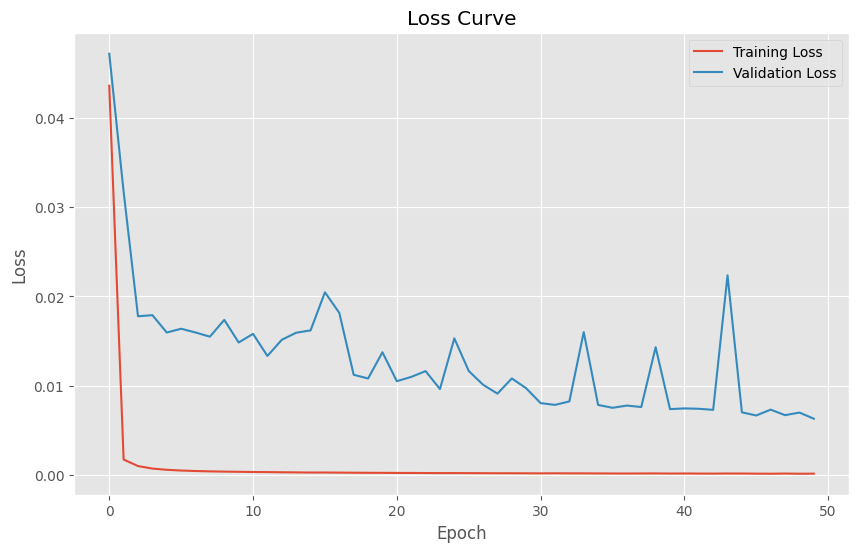

In [29]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model Usage and Validation

In [30]:
def predict_for_date(date, model, scaler, n_past, features_to_train_on_index, features_to_predict_index, return_values=False):
    # Get the index position of the prediction date
    date_index = df.index.get_loc(date)

    # Get the start index for the past data
    start_index = date_index - (n_past + n_future - 1)

    # Extract the past data based on the start index and n_past
    past_data = df.iloc[start_index:start_index + n_past]

    # Scale the past data using the fitted scaler
    past_data_scaled = scaler.transform(past_data)

    # Extract the features needed for training
    past_data_scaled_subset = past_data_scaled[:, features_to_train_on_index]

    # Convert the input data to a torch tensor
    input_data = torch.from_numpy(past_data_scaled_subset).float()

    # Convert the past data into the required input format for the model
    input_tensor = input_data.unsqueeze(0)

    # Use the trained model to predict the adjusted close price
    with torch.no_grad():
        model.eval()
        output_tensor = model(input_tensor)

    # Convert the output tensor to numpy array
    output_array = output_tensor.numpy()

    # Inverse scale the predicted value
    output_array_full = np.zeros((1, scaler.mean_.shape[0]))
    output_array_full[:, features_to_predict_index] = output_array
    predicted_value = scaler.inverse_transform(output_array_full)[0, features_to_predict_index]

    # Get the actual adjusted close price
    actual_value = df.iloc[date_index, features_to_predict_index]

    predicted_dict = {}
    actual_dict = {}
    for x, y in enumerate(features_to_predict):
        predicted_dict[y] = predicted_value[x]
        actual_dict[y] = actual_value[y]

    if return_values:
        return predicted_dict, actual_dict
    else:
        # Print the predicted value and a cross section of the actual values
        print(f'For {date}')
        for x, y in enumerate(features_to_predict):
            print(f'\nPredicted {y} = {predicted_value[x]}')
            print(f'Actual {y} = {actual_value[x]}')


In [31]:
# Set the date for which you want to predict the adjusted close price
prediction_date = '2023-05-15'

# Convert the prediction date to a pandas datetime object
prediction_date = pd.to_datetime(prediction_date, format='%Y-%m-%d')

# Call the prediction function
predict_for_date(prediction_date, model, scaler, n_past, features_to_train_on_index, features_to_predict_index)

For 2023-05-15 00:00:00

Predicted Adj Close = 109.72848506387257
Actual Adj Close = 111.19999694824219


In [44]:
def plot_predicted_vs_actual(start_date, model, scaler, n_past, features_to_train_on_index, features_to_predict_index):
    # Get the index position of the start date
    start_index = df.index.get_loc(start_date)

    # Get the corresponding dates for plotting
    dates = df.index[start_index:]

    # Initialize dictionaries to store predicted and actual values
    predicted_values = {feature: [] for feature in features_to_predict}
    actual_values = {feature: [] for feature in features_to_predict}

    # Iterate over the dates and predict the values
    for date in dates:
        predicted_value, actual_value = predict_for_date(date, model, scaler, n_past, features_to_train_on_index, features_to_predict_index, return_values=True)
        for feature in features_to_predict:
            predicted_values[feature].append(predicted_value[feature])
            actual_values[feature].append(actual_value[feature])

    # Create individual subplots for each feature
    num_plots = len(features_to_predict_index)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots), sharex=True)

    # Ensure that axes is always a list
    if num_plots == 1:
        axes = [axes]

    # Iterate over the features and plot the predicted and actual values
    for i, feature in enumerate(features_to_predict):
        ax = axes[i]
        ax.plot(dates, predicted_values[feature], label='Predicted ' + feature)
        ax.plot(dates, actual_values[feature], label='Actual ' + feature)
        ax.set_title('Predicted vs Actual ' + feature)
        ax.legend()

    # Set the x-axis label and grid for the last subplot
    axes[-1].set_xlabel('Date')
    axes[-1].grid(True)

    # Rotate x-axis tick labels for better visibility
    plt.xticks(rotation=45)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


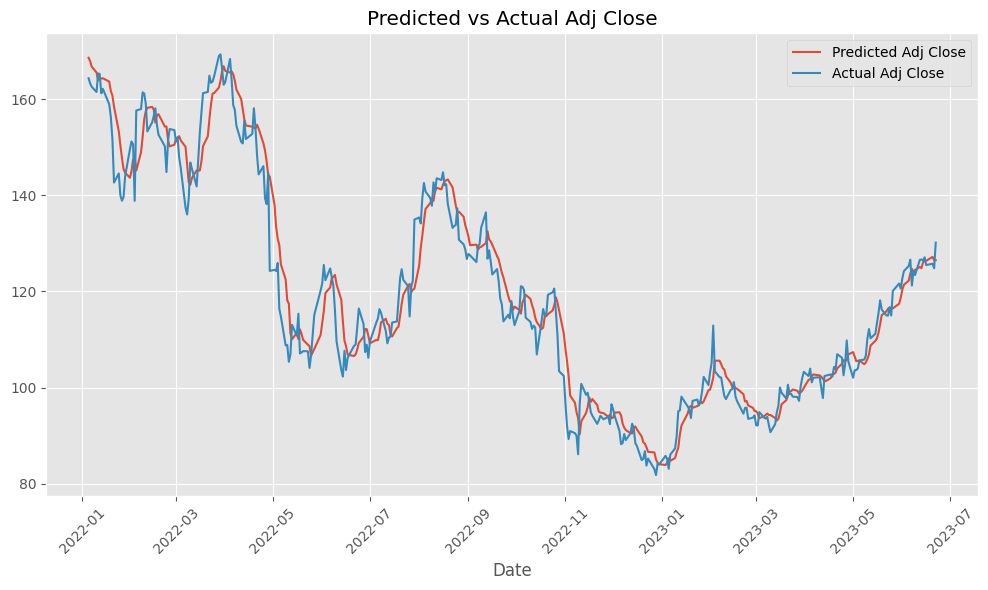

In [45]:
# Set the date for which you want to predict the adjusted close price
start_date = '2022-01-05'

# Convert the prediction date to a pandas datetime object
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')

# Call the plotting function
plot_predicted_vs_actual(start_date, model, scaler, n_past, features_to_train_on_index, features_to_predict_index)